In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from scipy.stats import f_oneway
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from ydata_profiling import ProfileReport


**Analyse et nettoyage des données**

In [3]:
df = pd.read_csv('../data/carprice.csv')

In [4]:
# nettoyage basique
df.columns = [col.strip() for col in df.columns]
df.columns = [col.replace(" ","_") for col in df.columns]
df.columns = [col.lower() for col in df.columns]

In [5]:
# affichage des valeurs de chaques colonnes pour analyse
for col in df.columns:
    unique_values = df[col].unique()
    print(f"colonne {col} : {unique_values}")

colonne car_id : [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205]
colonne symboling : [ 3  1  2  0 -1 -2]
colonne carname : ['alfa-romero giulia' 'alfa-romero stelvio' 'alfa-romero Quadrifoglio'
 'audi 100 ls' 'audi 

In [6]:
# retrait de la colonne car_id
df = df.drop("car_id", axis=1)

In [7]:
# conversion de la colonne wheelbase de pouces en centimètres
df["wheelbase"] = df["wheelbase"].apply(lambda x: round(x * 2.54, 1))

# conversion de la colonne carlength de pouces en centimètres
df["carlength"] = df["carlength"].apply(lambda x: round(x * 2.54, 1))

# conversion de la colonne carwidth de pouces en centimètres
df["carwidth"] = df["carwidth"].apply(lambda x: round(x * 2.54, 1))

# conversion de la colonne carheight de pouces en centimètres
df["carheight"] = df["carheight"].apply(lambda x: round(x * 2.54, 1))

# conversion de la colonne curbweight de livres en kg
df["curbweight"] = df["curbweight"].apply(lambda x: x*0.453592)

# conversion de la colonne citympg de miles/gallon en litres/100km
df["citympg"] = df["citympg"].apply(lambda x: 235.215 / x)

# conversion de la colonne highwaympg de miles/gallon en litres/100km
df["highwaympg"] = df["highwaympg"].apply(lambda x: 235.215 / x)

In [8]:
# creation des colonnes marque et modele
df[['marque', 'modele']] = df['carname'].str.split(' ', 1, expand=True)
df = df.drop("carname", axis=1)

/tmp/ipykernel_24783/1838856644.py:2: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[['marque', 'modele']] = df['carname'].str.split(' ', 1, expand=True)


In [9]:
# corriger les erreurs d'othographes sur les marques de voiture
df['marque'] = df['marque'].replace({
    'alfa-romero' : 'alfa-romeo',
    'maxda': 'mazda',
    'toyouta': 'toyota',
    'vokswagen': 'volkswagen',
    'vw': 'volkswagen',
    'Nissan': 'nissan',
    'porcshce': 'porsche'
})

In [10]:
# définition d'un dictionnaire de correspondance entre les titres anglais et les titres français
correspondance = {
    "symboling": "risque_assurance",
    "fueltype": "carburant",
    "aspiration": "turbo",
    "doornumber": "nombre_portes",
    "carbody": "type_vehicule",
    "drivewheel": "roues_motrices",
    "enginelocation": "emplacement_moteur",
    "enginesize" : "taille_moteur",
    "wheelbase": "empattement",
    "carlength" : "longueur_voiture",
    "carwidth" : "largeur_voiture",
    "carheight" : "hauteur_voiture",
    "curbweight": "poids_voiture",
    "enginetype": "type_moteur",
    "cylindernumber": "nombre_cylindres",
    "fuelsystem": "systeme_carburant",
    "boreratio": "taux_alesage",
    "stroke": "course",
    "compressionratio": "taux_compression",
    "horsepower": "puissance",
    "peakrpm": "tour_moteur",
    "citympg": "consommation_ville",
    "highwaympg": "consommation_autoroute",
    "price": "prix"
}

# renommage des colonnes
df = df.rename(columns=correspondance)

In [11]:
# affichage des valeurs de chaques colonnes pour analyse
for col in df.columns:
    unique_values = df[col].unique()
    print(f"colonne {col} : {unique_values}")


colonne risque_assurance : [ 3  1  2  0 -1 -2]
colonne carburant : ['gas' 'diesel']
colonne turbo : ['std' 'turbo']
colonne nombre_portes : ['two' 'four']
colonne type_vehicule : ['convertible' 'hatchback' 'sedan' 'wagon' 'hardtop']
colonne roues_motrices : ['rwd' 'fwd' '4wd']
colonne emplacement_moteur : ['front' 'rear']
colonne empattement : [225.  240.  253.5 252.5 268.7 252.7 257.  262.9 279.4 224.5 238.  262.4
 243.6 220.  245.1 239.5 243.8 287.  259.1 236.5 242.1 251.  266.4 271.
 293.6 245.4 307.1 284.5 260.9 236.2 244.6 241.6 246.9 255.  231.9 252.
 274.1 290.1 274.3 227.3 249.9 244.1 251.7 237.  246.4 246.1 243.1 260.1
 261.4 265.4 247.1 264.9 277.1]
colonne longueur_voiture : [428.8 434.8 448.6 450.3 489.5 452.6 449.1 480.1 492.3 500.4 358.4 396.
 403.4 399.5 443.5 439.9 367.3 381.  415.  399.  425.4 445.5 429.5 433.6
 438.4 507.  486.9 404.1 423.7 429.3 451.6 444.5 484.9 476.2 514.6 458.
 528.6 506.  453.1 439.4 437.9 419.9 432.3 420.6 412.5 440.4 461.5 468.9
 453.4 474.2 50

**analyse avec describe / corr / ProfileReport**

In [12]:
df.describe()

,risque_assurance,empattement,longueur_voiture,largeur_voiture,hauteur_voiture,poids_voiture,taille_moteur,taux_alesage,course,taux_compression,puissance,tour_moteur,consommation_ville,consommation_autoroute,prix
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.834146,250.838537,442.084390,167.412195,136.458537,1159.184227,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,9.958628,8.041698,13276.710571
std,1.245307,15.296861,31.345726,5.443272,6.208129,236.176375,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,2.575458,1.851475,7988.852332
min,-2.000000,220.000000,358.400000,153.200000,121.400000,674.944896,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,4.800306,4.355833,5118.000000
25%,0.000000,240.000000,422.400000,162.800000,132.100000,972.954840,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,7.840500,6.918088,7788.000000
50%,1.000000,246.400000,439.900000,166.400000,137.400000,1094.971088,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,9.800625,7.840500,10295.000000
75%,2.000000,260.100000,465.100000,169.900000,141.000000,1331.292520,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,12.379737,9.408600,16503.000000
max,3.000000,307.100000,528.600000,183.600000,151.900000,1844.305072,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,18.093462,14.700938,45400.000000


In [13]:
df.corr()

/tmp/ipykernel_24783/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,risque_assurance,empattement,longueur_voiture,largeur_voiture,hauteur_voiture,poids_voiture,taille_moteur,taux_alesage,course,taux_compression,puissance,tour_moteur,consommation_ville,consommation_autoroute,prix
risque_assurance,1.000000,-0.531977,-0.357576,-0.232268,-0.540228,-0.227691,-0.105790,-0.130051,-0.008735,-0.178515,0.070873,0.273606,0.063165,-0.030190,-0.079978
empattement,-0.531977,1.000000,0.874416,0.794609,0.589534,0.776324,0.569194,0.488711,0.160907,0.249757,0.353051,-0.360761,0.473983,0.578142,0.577594
longueur_voiture,-0.357576,0.874416,1.000000,0.840500,0.491738,0.877678,0.683314,0.606499,0.129296,0.158336,0.552660,-0.287082,0.659237,0.711639,0.683018
largeur_voiture,-0.232268,0.794609,0.840500,1.000000,0.278756,0.866561,0.735328,0.557856,0.184019,0.181158,0.640752,-0.218656,0.682968,0.728163,0.759566
hauteur_voiture,-0.540228,0.589534,0.491738,0.278756,1.000000,0.296122,0.067582,0.171588,-0.054890,0.261297,-0.107989,-0.319793,-0.001481,0.086400,0.119901
poids_voiture,-0.227691,0.776324,0.877678,0.866561,0.296122,1.000000,0.850594,0.648480,0.168790,0.151362,0.750739,-0.266243,0.791911,0.836742,0.835305
taille_moteur,-0.105790,0.569194,0.683314,0.735328,0.067582,0.850594,1.000000,0.583774,0.203129,0.028971,0.809769,-0.244660,0.744952,0.777077,0.874145
taux_alesage,-0.130051,0.488711,0.606499,0.557856,0.171588,0.648480,0.583774,1.000000,-0.055909,0.005197,0.573677,-0.254976,0.555989,0.551965,0.553173
course,-0.008735,0.160907,0.129296,0.184019,-0.054890,0.168790,0.203129,-0.055909,1.000000,0.186110,0.080940,-0.067964,0.042508,0.055402,0.079443
taux_compression,-0.178515,0.249757,0.158336,0.181158,0.261297,0.151362,0.028971,0.005197,0.186110,1.000000,-0.204326,-0.435741,-0.296964,-0.223411,0.067984


In [14]:
profile = ProfileReport(df, title="Profiling Report")
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [36]:
# df.to_csv('data_utilisable.csv', index=False)

**Modélisation du problème**

In [37]:
df

,risque_assurance,carburant,turbo,nombre_portes,type_vehicule,roues_motrices,emplacement_moteur,empattement,longueur_voiture,largeur_voiture,...,taux_alesage,course,taux_compression,puissance,tour_moteur,consommation_ville,consommation_autoroute,prix,marque,modele
0,3,gas,std,two,convertible,rwd,front,225.0,428.8,162.8,...,3.47,2.68,9.0,111,5000,11.200714,8.711667,13495.0,alfa-romeo,giulia
1,3,gas,std,two,convertible,rwd,front,225.0,428.8,162.8,...,3.47,2.68,9.0,111,5000,11.200714,8.711667,16500.0,alfa-romeo,stelvio
2,1,gas,std,two,hatchback,rwd,front,240.0,434.8,166.4,...,2.68,3.47,9.0,154,5000,12.379737,9.046731,16500.0,alfa-romeo,Quadrifoglio
3,2,gas,std,four,sedan,fwd,front,253.5,448.6,168.1,...,3.19,3.40,10.0,102,5500,9.800625,7.840500,13950.0,audi,100 ls
4,2,gas,std,four,sedan,4wd,front,252.5,448.6,168.7,...,3.19,3.40,8.0,115,5500,13.067500,10.691591,17450.0,audi,100ls
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,gas,std,four,sedan,rwd,front,277.1,479.6,175.0,...,3.78,3.15,9.5,114,5400,10.226739,8.400536,16845.0,volvo,145e (sw)
201,-1,gas,turbo,four,sedan,rwd,front,277.1,479.6,174.8,...,3.78,3.15,8.7,160,5300,12.379737,9.408600,19045.0,volvo,144ea
202,-1,gas,std,four,sedan,rwd,front,277.1,479.6,175.0,...,3.58,2.87,8.8,134,5500,13.067500,10.226739,21485.0,volvo,244dl
203,-1,diesel,turbo,four,sedan,rwd,front,277.1,479.6,175.0,...,3.01,3.40,23.0,106,4800,9.046731,8.711667,22470.0,volvo,246


**pipeline / RandomForestRegressor / train_test_split**

In [38]:
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, SGDRegressor
import pickle

# df['nombre_cylindres'] = df['nombre_cylindres'].replace({'four': 4, 'six': 6, 'five': 5, 'three': 3, 'twelve': 12, 'two': 2, 'eight': 8})

X = df.drop("prix", axis=1)
y = df['prix']

numerical_cols = make_column_selector(dtype_include=np.number)
categorical_cols = make_column_selector(dtype_exclude=np.number)

numerical_pipeline = make_pipeline(SimpleImputer(), StandardScaler())
categorical_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))

preprocessor = make_column_transformer((numerical_pipeline, numerical_cols), (categorical_pipeline, categorical_cols))

# model = make_pipeline(preprocessor, LinearRegression())
# Train set : 0.9972321236089595
# Test set : 0.7731379818313524

# model = make_pipeline(preprocessor, SGDRegressor())
# Train set : 0.9874957836787158
# Test set : 0.8881041863953467

params = {
    'n_estimators': 100, 
    'criterion': 'squared_error', 
    'max_depth': None, 
    'min_samples_split': 2, 
    'min_samples_leaf': 1, 
    'min_weight_fraction_leaf': 0.0, 
    'max_features': 1.0, 
    'max_leaf_nodes': None, 
    'min_impurity_decrease': 0.0, 
    'bootstrap': True, 
    'oob_score': False, 
    'n_jobs': None, 
    'random_state': None, 
    'verbose': 0, 
    'warm_start': False, 
    'ccp_alpha': 0.0, 
    'max_samples': None
}

model = make_pipeline(preprocessor, RandomForestRegressor())
# Train set : 0.9884544443964661
# Test set : 0.9548282323216438


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)
    # code pour exporter dans un fichier le modele

print('Train set :', model.score(X_train, y_train))
print('Test set :', model.score(X_test, y_test))

Train set : 0.986521709643529
Test set : 0.9558676591114607


[ 13  42  72 101 131]


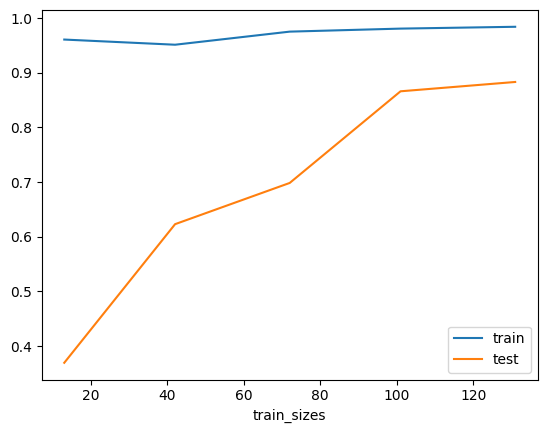

In [39]:
from sklearn.model_selection import learning_curve

N, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5)
# N, train_scores, test_scores = learning_curve(model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 5), cv=5)

print(N)
plt.plot(N, train_scores.mean(axis=1), label='train')
plt.plot(N, test_scores.mean(axis=1), label='test')
plt.xlabel('train_sizes')
plt.legend()

In [40]:
y_pred = model.predict(X_test)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import *

r2 = r2_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
print('R2 :', r2)
print('RMSE :', sqrt(MSE))
print('MAE :', MAE)

R2 : 0.9558676591114607
RMSE : 1866.543447277085
MAE : 1285.7397073170735


**hyperparametre tuning avec GridSearchCV**

In [41]:
from sklearn.model_selection import GridSearchCV
import numpy as np

# n_estimators = np.arange(1,1000)
n_estimators = list(range(10, 1000, 50))
criterion = ['squared_error', 'absolute_error']
max_depth = [4, 5, 6, 7, 8]
min_samples_split = [2, 3, 5, 10]
min_samples_leaf = [1, 2, 4]
min_weight_fraction_leaf = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
max_features = ['auto', 'sqrt', 'log2']
max_leaf_nodes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
min_impurity_decrease = [0.0]
bootstrap = [True, False]
oob_score = [True, False]
n_jobs = [None]
random_state = [42]
verbose = [0]
warm_start = [True, False]
ccp_alpha = [0.0]
max_samples = [None]

param_grid = {
    'n_estimators': n_estimators,
    'criterion': criterion, 
    'max_depth': max_depth, 
    # 'min_samples_split': min_samples_split, 
    # 'min_samples_leaf': min_samples_leaf, 
    # 'min_weight_fraction_leaf': min_weight_fraction_leaf, 
    'max_features': max_features, 
    # 'max_leaf_nodes': max_leaf_nodes, 
    # 'min_impurity_decrease': min_impurity_decrease, 
    # 'bootstrap': bootstrap, 
    # 'oob_score': oob_score, 
    # 'n_jobs': n_jobs, 
    # 'random_state': random_state, 
    # 'verbose': verbose, 
    # 'warm_start': warm_start, 
    # 'ccp_alpha': ccp_alpha, 
    # 'max_samples': max_samples
}

param_grid2 = {
    'verbose': verbose
#     'memory': [False, True],
#     'steps': [1]
}



grid = GridSearchCV(estimator=model, param_grid=param_grid2, cv=5)

grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f5be63f1cd0>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f5be63f1ee0>)])),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             param_grid={'verbose': [0]})

In [42]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

ValueError: Invalid parameter 'model' for estimator Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5be404f160>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5be4003c10>)])),
                ('randomforestregressor', RandomForestRegressor())]). Valid parameters are: ['memory', 'steps', 'verbose'].

In [ ]:
grid.best_score_

In [ ]:
grid.best_params_

In [ ]:
model_grid = grid.best_estimator_

In [ ]:
print('Train set :', model_grid.score(X_train, y_train))
print('Test set :', model_grid.score(X_test, y_test))

In [ ]:
liste = ['carburant', 'turbo', 'nombre_portes', 'type_vehicule', 'roues_motrices', 'emplacement_moteur', 'type_moteur', 'nombre_cylindres', 'systeme_carburant', 'marque', 'modele']
for l in liste:
    print(df[l].unique())